In [1]:
import numpy as np
import sys
import matplotlib.colors as colors
from scipy.interpolate import griddata, NearestNDInterpolator
import matplotlib.pyplot as plt
from numpy import uint32, uint64, float64, float32, linspace, array, logspace, sin, cos, pi, arange, sqrt, arctan2, arccos
from arepy.read_write import binary_read as rsnap
from arepy.read_write import binary_write as wsnap
from arepy.utility import cgs_constants as cgs
%matplotlib inline

In [2]:
print(np.zeros(1))

[0.]


In [17]:
def inject_Tracers_Rect_Weighted(data,header,lowerx,lowery,lowerz,upperx,uppery,upperz):
        ## oh boy here we gooooo
    xpos, ypos, zpos = data['pos'][:,0], data['pos'][:,1], data['pos'][:,2]
    myregion = np.where(np.logical_and(np.greater(xpos,lowerx),
                                      np.logical_and(np.less(xpos,upperx),
                                                             np.logical_and(np.greater(ypos,lowery),
                                                                           np.logical_and(np.less(ypos,uppery),
                                                                                         np.logical_and(np.greater(zpos,lowerz),np.less(zpos,upperz)))))))
    ## 
    cell_ID = data['id']
    myregion_obj = myregion
    myregion = myregion[0]
    print myregion.shape
    #print cell_ID.shape
    print data['mass'].shape
    
    tpm = 10.
    # define numtrace
    numtrace = np.zeros(data['mass'].shape,dtype=uint32)
    for i in myregion:
        #print i
        numtrace[i] = uint32(np.rint(data['mass'][i]*tpm))
        #print data['mass'][i]
        
    nt = sum(numtrace)
    print nt
    #print numtrace[myregion]
    #print numtrace.shape
    #print np.where(numtrace!=0)[0].shape
    
    tracerid = np.arange(1,nt+1,dtype=uint32)
    parentid = np.zeros(nt,dtype=uint32)
                                       
    header["num_particles_total"][2] = uint32(nt)
    header["num_particles"][2] = uint32(nt)
    
    count_total = 0
    for i in myregion:
        ntcount = 0
        while ntcount < numtrace[i]:
            parentid[count_total] = uint32(data['id'][i])
            ntcount = ntcount+1
            count_total = count_total+1
        #print ntcount
    
            
    data['numtrace']=numtrace
    data['tracerid']=tracerid
    data['parentid']=parentid
                        
    return data, header, myregion 

def inject_Tracers_Everywhere(data,header,tpm):
    #xpos, ypos, zpos = data['pos'][:,0], data['pos'][:,1], data['pos'][:,2]
    ## 
    #cell_ID = data['id']
    #tpm = uint32(tpm)
    print "The number of arepo cells is "+ str(len(data['mass']))
    
    cell_ID = data['id']
    cell_mass = data['mass']
    # define numtrace
    #data['numtrace'] = uint32(np.rint(data['mass'])*tpm)
    data['numtrace'] = np.zeros(len(cell_mass),dtype=uint32)
    data['numtrace'] = uint32(np.floor(cell_mass*tpm))
    nt = sum(data['numtrace'])
    print "nt is " + str(nt)
    data['tracerid'] = np.arange(1,nt+1,dtype=uint64)
    data['parentid'] = np.zeros(nt,dtype=uint64)
    ph = 0 #placeholder for tracer number
    for i in range(len(cell_ID)):
        data['parentid'][ph:(ph+data['numtrace'][i])] = uint64(data['id'][i])
        ph += data['numtrace'][i]
        #dph = np.ceil(cell_mass[i]*tpm)
        #data['parentid'][int(ph):int(ph+dph)-1]=cell_ID[i]
        #ph+=dph
    print "ph is " + str(ph)    
                                       
    header["num_particles_total"][2] = nt
    header["num_particles"][2] = nt
    
    print "Length of tracerid is " + str(len(data['tracerid'])) + " of type " + str(type(data['tracerid'][0])) 
    print "Length of parentid is " + str(len(data['parentid'])) + " of type " + str(type(data['parentid'][0])) 
    print "Length of numtrace is " + str(len(data['numtrace'])) + " of type " + str(type(data['numtrace'][0]))   
                        
    return data, header 


def inject_single_tracer(data,header):
    cell_mass = data['mass']
    cond = np.argmax(cell_mass)
    data['numtrace']=np.zeros(len(cell_mass),dtype=uint32)
    data['numtrace'][cond]=1
    data['tracerid']=np.array([1],dtype=uint64)
    data['parentid']=np.array([data['id'][cond]],dtype=uint64)
    header["num_particles_total"][2] = 1
    header["num_particles"][2] = 1
    return data, header

def inject_MCTP_by_mass(data,header,tpm):

    print "The number of arepo cells is "+ str(len(data['mass']))
    
    cell_ID = data['id']
    cell_mass = data['mass']
    data['numtrace'] = np.zeros(len(cell_mass),dtype=uint32)
    data['numtrace'] = uint32(np.floor(cell_mass*tpm))
    nt = sum(data['numtrace'])
    print "nt is " + str(nt)
    data['tracerid'] = np.arange(1,nt+1,dtype=uint64)
    data['parentid'] = np.repeat(data['id'],data['numtrace'])
                                       
    header["num_particles_total"][2] = nt
    header["num_particles"][2] = nt
    
    print "Length of tracerid is " + str(len(data['tracerid'])) + " of type " + str(type(data['tracerid'][0])) 
    print "Length of parentid is " + str(len(data['parentid'])) + " of type " + str(type(data['parentid'][0])) 
    print "Length of numtrace is " + str(len(data['numtrace'])) + " of type " + str(type(data['numtrace'][0]))   
                        
    return data, header 


In [11]:
#################################
### Load snapshot with no tracers
#################################
rsnap.io_flags['mc_tracer']=False
rsnap.io_flags['sgchem'] = True
data, header = rsnap.read_snapshot('/home/hd/hd_hd/hd_rm238/mattias_arepo/whole_disk_100')

Loading file /home/hd/hd_hd/hd_rm238/mattias_arepo/whole_disk_100
Particles [53662787        0        0        0        0        0]
Masses [0. 0. 0. 0. 0. 0.]
Gas particles 53662787
Time =  [1.00048828]
Precision: Float
ID type:  <type 'numpy.uint64'>


In [6]:
####################################################
### Single Tracer Test
####################################################
data_test, header_test = inject_single_tracer(data,header)
#print(data_test['numtrace'],data_test['parentid'],data_test['tracerid'])
print(np.argmax(data_test['mass']), data_test['id'][25568111])
#print header_test
print(data_test['numtrace'].shape)
print(data_test['parentid'])
print(data_test['tracerid'])
print(type(data_test['numtrace'][0]),type(data_test['parentid'][0]),type(data_test['tracerid'][0]))
print(data_test['pos'].T.shape)
### Write new snapshot with tracers
wsnap.io_flags['mc_tracer']=True
wsnap.io_flags['sgchem'] = True
wsnap.write_snapshot(data=data_test,filename='/beegfs/work/workspace/ws/hd_rm238-m_production-0/sim_test/OUTPUT/whole_disk_100',header=header_test)
#wsnap.write_snapshot(data=data_test,filename='/home/hd/hd_hd/hd_rm238/mattias_arepo/mattia_sims_3-18-19/with_tracers_test/whole_disk_100',header=header_test)
print("written")




In [22]:
###############################################################
### New (7-3-19) Tracer by Mass injection test
###############################################################
dataTr, headerTr = inject_MCTP_by_mass(data,header,0.1)



The number of arepo cells is 53662787
nt is 117899847
Length of tracerid is 117899847 of type <type 'numpy.uint64'>
Length of parentid is 117899847 of type <type 'numpy.uint64'>
Length of numtrace is 53662787 of type <type 'numpy.uint32'>


In [24]:
#######################
### write with tracers
#######################
### Write new snapshot with tracers
wsnap.io_flags['mc_tracer']=True
wsnap.io_flags['sgchem'] = True
wsnap.write_snapshot(data=data_test,filename='/beegfs/work/workspace/ws/hd_rm238-m_production-0/sim_test/OUTPUT/whole_disk_100',header=header_test)
#wsnap.write_snapshot(data=dataTr,filename='/home/hd/hd_hd/hd_rm238/mattias_arepo/mattia_sims_3-18-19/with_tracers/whole_disk_100',header=headerTr)
print ("written")


written


In [20]:
##### testing np.repeat
a1 = [1,2,3,2,4]
a2 = [2,2,3,2,1]
print np.repeat(a1,a2)

[1 1 2 2 3 3 3 2 2 4]


In [25]:
rsnap.io_flags['mc_tracer']=True
rsnap.io_flags['sgchem'] = True
data_test, header_test = rsnap.read_snapshot('/beegfs/work/workspace/ws/hd_rm238-m_production-0/sim_test/OUTPUT/whole_disk_100')

Loading file /beegfs/work/workspace/ws/hd_rm238-m_production-0/sim_test/OUTPUT/whole_disk_100
Particles [53662787        0        1        0        0        0]
Masses [0. 0. 0. 0. 0. 0.]
Gas particles 53662787
Tracer particles 1
Time =  [1.00048828]
Precision: Float
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint64'>


In [14]:
print dataTr['numtrace'][147], dataTr['mass'][147]
print len(np.where(uint32(dataTr['numtrace']) != uint32(0.1*np.floor(dataTr['mass'])))[0])
print len(np.where(dataTr['id'][147]==dataTr['parentid'])[0])

2 24.28899
0
2


In [ ]:
print dataTr['numtrace'][140], dataTr['mass'][140]
print len(np.where(dataTr['id'][140]==dataTr['parentid'])[0])

In [20]:
### inject tracers everywhere (takes some time... ~5 minutes usually)

dataTr, headerTr = inject_Tracers_Everywhere(data,header,tpm=0.1)
# nt = 1
# dataTr, headerTr = data, header
# dataTr['tracerid'] = np.arange(1,nt+1,dtype=uint32)
# dataTr['parentid'] = np.zeros(nt,dtype=uint32)
# dataTr['parentid'][0]=data['id'][0]
# dataTr['numtrace'] = np.zeros(data['id'],dtype=uint32)
# dataTr['numtrace'][0] = uint32(1)
# headerTr["num_particles_total"][2] = uint32(nt)
# headerTr["num_particles"][2] = uint32(nt)

The number of arepo cells is 53662787
nt is 117899847
ph is 117899847
Length of tracerid is 117899847 of type <type 'numpy.uint32'>
Length of parentid is 117899847 of type <type 'numpy.uint64'>
Length of numtrace is 53662787 of type <type 'numpy.uint32'>


In [21]:
print len(dataTr['tracerid'])
print len(dataTr['parentid'])
print dataTr['tracerid']
print dataTr['parentid']
print np.median(dataTr['mass']), np.median(dataTr['numtrace'])

117899847
117899847
[        1         2         3 ... 117899845 117899846 117899847]
[205803945 343785557 335587912 ...  14402182 315933585 375004063]
29.930378 2.0


In [19]:
print len(np.where(dataTr['parentid']==0)[0])

0


In [22]:
### Write new snapshot with tracers
wsnap.io_flags['mc_tracer']=True
wsnap.io_flags['sgchem'] = True
wsnap.write_snapshot(data=dataTr,filename='/home/hd/hd_hd/hd_rm238/mattias_arepo/mattia_sims_3-18-19/with_tracers/whole_disk_100',header=headerTr)
print "written"

written


In [10]:
#print dataTr['tracerid'].itemsize
for i in dataTr.keys(): print i, dataTr[i].itemsize


u_therm 4
numtrace 4
tracerid 8
pos 4
tdust 4
mass 4
rho 4
parentid 8
vel 4
chem 4
id 8


In [23]:
### troubleshooting tracer injection
rsnap.io_flags['mc_tracer']=True
rsnap.io_flags['sgchem'] = True
data_new, header_new = rsnap.read_snapshot('/home/hd/hd_hd/hd_rm238/mattias_arepo/mattia_sims_3-18-19/with_tracers/whole_disk_100')


############################

Loading file /home/hd/hd_hd/hd_rm238/mattias_arepo/mattia_sims_3-18-19/with_tracers/whole_disk_100
Particles [ 53662787         0 117899847         0         0         0]
Masses [0. 0. 0. 0. 0. 0.]
Gas particles 53662787
Tracer particles 117899847
Time =  [1.00048828]
Precision: Float
ID type:  <type 'numpy.uint64'>
ID type:  <type 'numpy.uint32'>
ID type:  <type 'numpy.uint64'>


In [24]:
print data_new['numtrace'].shape
print data_new['tracerid'].shape
print data_new['parentid'].shape

(53662787,)
(117899847,)
(117899847,)


In [16]:
print len(np.where(uint32(dataTr['numtrace']) != uint32(np.floor(0.5*dataTr['mass'])))[0])

0


In [29]:
### Inject tracers in a rectangular area
xmin, xmax = -2., 0.
ymin, ymax = 7., 9.
zmin, zmax = 9., 11.

xmin += 120.
xmax += 120.
ymin += 120.
ymax += 120.

# xmin, xmax = 110., 112.
# ymin, ymax = 130., 132.
# zmin, zmax = 9., 11.

dataTr, headerTr, myregion = inject_Tracers_Rect_Weighted(data,header,xmin,ymin,zmin,xmax,ymax,zmax)

(98,)
(1419193,)
8598022


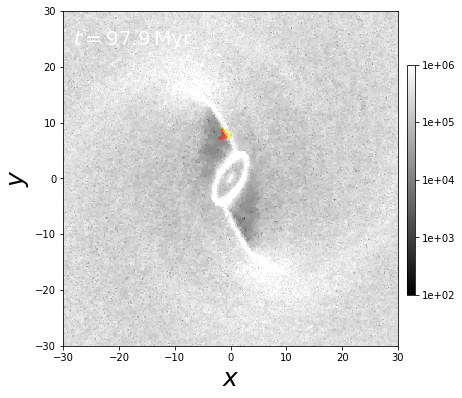

In [30]:
### Plot color tracer density over grayscale

t = headerTr['time']
x,y,z=dataTr['pos'].T
xTr,yTr,zTr = x-120., y-120., z-120.
x,y,z = x-120.0, y-120.0, z-10.0

rho = dataTr['rho']
masses = dataTr['mass']
ii = np.where(dataTr['numtrace']>0)
rho_T = np.zeros(rho.shape)
rho_T.fill(np.nan)
rho_T[ii] = rho[ii]
  
points = np.vstack((x,y,z)).T
rhof = NearestNDInterpolator(points,rho)
points_T = np.vstack((x,y,z)).T
rhof_T = NearestNDInterpolator(points_T,rho_T)
Nx, Ny, Nz = 601, 601, 11
plotrange=30
zslice=5
xgrid, ygrid, zgrid = linspace(-plotrange,plotrange,Nx), linspace(-plotrange,plotrange,Ny), linspace(-10,10,Nz)
XGRID,YGRID,ZGRID = np.meshgrid(xgrid,ygrid,zgrid)
RHO = rhof(XGRID,YGRID,ZGRID)
xgrid_T, ygrid_T, zgrid_T = linspace(-plotrange,plotrange,Nx), linspace(-plotrange,plotrange,Ny), linspace(-10,10,Nz)
XGRID_T,YGRID_T,ZGRID_T = np.meshgrid(xgrid_T,ygrid_T,zgrid_T)
RHO_T = rhof_T(XGRID_T,YGRID_T,ZGRID_T)
  
# plot
fig, ax = plt.subplots(1,1,figsize=(6,8))
u = 1.0
extent = (xgrid.min()/u,xgrid.max()/u,ygrid.min()/u,ygrid.max()/u)
levels = logspace(2,6,256)
levels_T = levels = logspace(2,6,256)
norm = colors.BoundaryNorm(levels, 256)
norm_T = colors.BoundaryNorm(levels_T, 256)
im = ax.imshow(RHO[:,:,zslice],origin='l',norm=norm,extent=extent,cmap='gray',interpolation='nearest')
im_T = ax.imshow(RHO_T[:,:,zslice],origin='l',norm=norm_T,extent=extent,cmap='inferno',interpolation='nearest')
#ax.scatter(xTr[ii],yTr[ii])
ax.set_xlabel(r'$x$',fontsize=25)
ax.set_ylabel(r'$y$',fontsize=25)
ax.annotate(r'$t=%.1f\,\rm Myr$'%(t*97.856),xy=(0.03,0.9),xycoords='axes fraction',fontsize=20,color='w')
#ax.set_xlim(xgrid.min()/u,xgrid.max()/u)
#ax.set_ylim(ygrid.min()/u,ygrid.max()/u)
fig.subplots_adjust(right=0.9)
fig.subplots_adjust(wspace=0.0,hspace=0.0)
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
plt.colorbar(im,cax=cbar_ax,ticks=logspace(-10,10,21),format='%.0e')

plt.show()



In [17]:
### Write new snapshot with tracers
wsnap.io_flags['mc_tracer']=True
wsnap.write_snapshot(data=dataTr,filename='/home/hph16101/arepo_sims_hpc_reftest/sim_refine_shock/whole_disk_100',header=headerTr)
print "written"

written


In [18]:
### Read in Snapshot with tracers
data2, header2 = rsnap.read_snapshot('/home/hph16101/arepo_sims_hpc_reftest/sim_refine_shock/whole_disk_100')

Loading file /home/hph16101/arepo_sims_hpc_reftest/sim_refine_ring/whole_disk_100
Particles [ 1419193        0 50529722        0        0        0]
Masses [0. 0. 0. 0. 0. 0.]
Gas particles 1419193
Tracer particles 50529722
Time =  [1.]
Precision: Float
ID type:  <type 'numpy.uint32'>
ID type:  <type 'numpy.uint32'>
ID type:  <type 'numpy.uint32'>


In [19]:
print data2['parentid'].shape
print data2['tracerid'].shape
print data2['numtrace'].shape
print data2['mass'].shape
print data2['id'][np.where(data2['numtrace']!=0)]
print data2['parentid']
print data2['tracerid']

(50529722,)
(50529722,)
(1419193,)
(1419193,)
[4136671 4129372 4138999 4127450 4140427 4130736 4070846 4149794 4141185
 4142554 4004444 4142985 4093650 4083221 3779064 4115562 4146135 4048841
 4129266 4046936 3782966 4151835 4135252 4121600 4105077 4135336 4113355
 4147176 4118363 4146850 4152038 4029221 4150791 4152039 4130734 4153494
 4084632 4113431 3827850 4150673 4152261 4153550 4148539 4153495 4073570
 4133692 4066626 4056792 4087360 4148540 4141188 4018623 4050689 4057227
 4022228 4127261 3929625 4129673 4076557 4064263 3877092 4053599 4083130
 4076400 4028507 3916238 4005131 4092071 3981771 4092311 4083129 4092072
 4127262 3631322 4042742 4080865 4029211 4086189 4140954 4136037 4147795
 4061949 4118365 4019974 4021639 3997325 4082415 4111888 4071795 3988321
 4004449 4019459 3993513 3944807 3993031 4102437 4124518 4088265 4128891
 3995725 4104295 4063394 4055528 3987001 3826262 4133132 3969681 4141187
 4102500 4135258 4015039 3912559 4148541 3746029 3775473 4148321 4149213
 3961

In [ ]:
abc = np.where(data2['parentid']==2829094)
print abc[0].shape
print data2['mass'][np.where(data2['id']==2829094)]